### Task

write a program on Ising MC modeling on freezing melting of a nanoparticle. Simulate for different NP sizes. Explain Hill's theory of NP melting-freezing

In [349]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from numba import jit
from IPython.display import clear_output

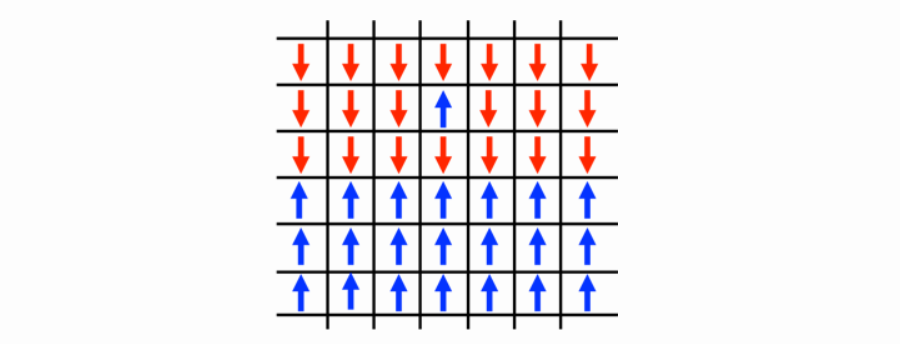

In [350]:
# initial accusations
def init_accusations(L=30, mode='random', lw = 8):
    #lattice
    if mode == 'random':
        matrix = np.random.randint(2, size=(L, L), dtype=np.int8) * 2 - 1
        
    elif mode == 'filled':
        matrix = np.ones((L, L))
    
    elif mode == 'grid':
        matrix = np.ones((L, L))
        
        cube = -1.0 * np.ones((lw, lw))
        temp_x = 0
        while(temp_x + lw <= len(matrix)):
            temp_y = 0
            while(temp_y + lw <= len(matrix)):
                for i in range(lw):
                    for j in range(lw):
                        matrix[temp_x+i][temp_y+j]=cube[i][j]
                temp_y += lw
                cube *= -1.0 
            temp_x += lw
            cube *= -1.0 
            
            
    # round boundary
    for i in range(L):
        matrix[0][i] = 0
        matrix[i][0] = 0
        matrix[-1][i] = 0
        matrix[i][-1] = 0
            
    # cube
    N = int(L * L)
    x = np.zeros((N), dtype = np.int8)
    y = np.zeros((N), dtype = np.int8)
    
    k = 0
    x0 = 0
    y0 = 0
    for i in range(L):
        for j in range(L):
            x[k] = i
            y[k] = j
            k = k + 1
            
    return x, y, matrix, N

In [835]:
@jit(nopython=True) #computation accelerator
def est_E(matrix):
    L = len(matrix)
    E = 0
    
    for x_temp in range(1, L-1):
        for y_temp in range(1, L-1):
            
            # determine neighbours
            x_l = x_temp - 1 if x_temp > 0 else L - 1     # left
            x_r = x_temp + 1 if x_temp != L - 1 else 0    # right
            y_b = y_temp - 1 if y_temp > 0 else L - 1     # bottom
            y_t = y_temp + 1 if y_temp != L - 1 else 0    # top
            
            # calc flipping energy dE
            E += -1.0 * ( matrix[x_temp][y_temp] * matrix[x_l][y_temp] +\
                          matrix[x_temp][y_temp] * matrix[x_r][y_temp] +\
                          matrix[x_temp][y_temp] * matrix[x_temp][y_b] +\
                          matrix[x_temp][y_temp] * matrix[x_temp][y_t] )
            
    return E / 2

In [836]:
@jit(nopython=True) #computation accelerator
def run(matrix, T, mode='loop'):
    L = len(matrix)
    N = L * L
        
    if mode == 'loop':
        loop = int(10**7)
    elif mode == 'calc':
        loop = int(0.5 * N)
    
    E = np.zeros(loop)
    M = np.zeros(loop)
    
    for step in range(loop):
    
        # choose random spot on lattice
        x_temp = np.random.randint(1, L-1)
        y_temp = np.random.randint(1, L-1)
        
        # determine neighbours
        x_l = x_temp - 1 if x_temp > 0 else L - 1     # left
        x_r = x_temp + 1 if x_temp != L - 1 else 0    # right
        y_b = y_temp - 1 if y_temp > 0 else L - 1     # bottom
        y_t = y_temp + 1 if y_temp != L - 1 else 0    # top
        
        # calc flipping energy dE
        E_before_flip = -1.0 * ( matrix[x_temp][y_temp] * matrix[x_l][y_temp] +\
                                 matrix[x_temp][y_temp] * matrix[x_r][y_temp] +\
                                 matrix[x_temp][y_temp] * matrix[x_temp][y_b] +\
                                 matrix[x_temp][y_temp] * matrix[x_temp][y_t] )
        E_after_flip = -E_before_flip
        dE = E_after_flip - E_before_flip
        
        # flip
        if (dE <= 0):
            
            # flip spin
            matrix[x_temp][y_temp] *= -1
            
        else:
            
            # check random number
            rand_temp = np.random.uniform(0, 1)
            if (rand_temp < np.exp(-dE/T)):
                
                # flip spin
                matrix[x_temp][y_temp] *= -1
                
        if mode == 'calc':
            E[step] = est_E(matrix)
            M[step] = matrix.sum()
        
    return matrix, E, M

In [682]:
def plot_lattice(matrix, ax, title='Matrix (lattice)'):
    ax.imshow(matrix.T, cmap='bwr')
    ax.set_title(title)
    #ax.set_xlabel('x'), ax.set_ylabel('y')
    #plt.show()

def plot_lattice_plt(matrix, title='Matrix (lattice)', size=10):
    plt.figure(figsize=(size, size))
    plt.imshow(matrix.T, cmap='bwr')
    plt.title(title)
    plt.xlabel('x'), plt.ylabel('y')
    plt.show()

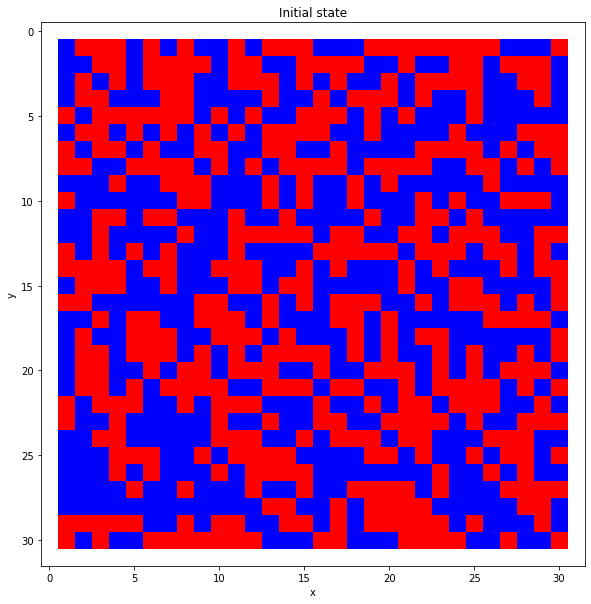

In [683]:
x, y, matrix, N = init_accusations(L=32, mode='random')
plot_lattice_plt(matrix, 'Initial state')

In [684]:
T_arr = np.linspace(0.01, 6, 100)
T_ = np.append(T_arr, T_arr[::-1])

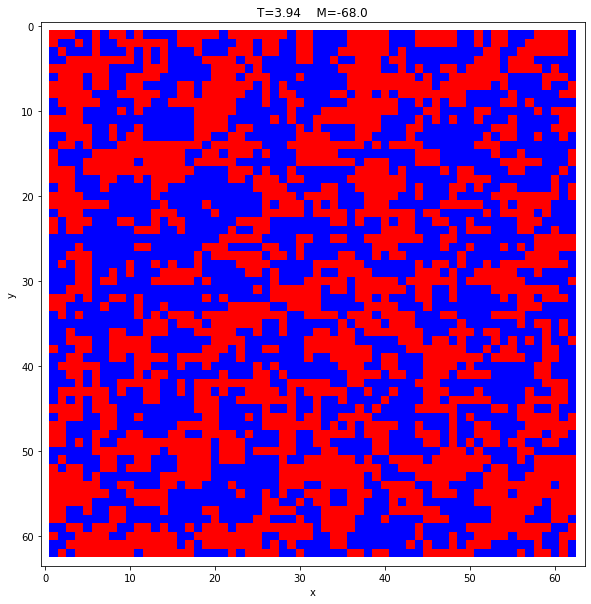

KeyboardInterrupt: 

In [852]:
length = 100
# formation of T array
T_arr = np.linspace(0.01, 6, length)
T_ = np.append(T_arr, T_arr[::-1])
# measures        
M_, M2_ = np.zeros(length * 2), np.zeros(length * 2)
E_, E2_ = np.zeros(length * 2), np.zeros(length * 2)
std_E = np.zeros(length * 2)
std_M = np.zeros(length * 2)
configurations = []
# init
x, y, init_matrix, N = init_accusations(L=64, mode='filled')
plot_lattice_plt(init_matrix, 'Initial state')
matrix = init_matrix.copy()
for T, step in zip(T_, range(length * 2)):

    matrix, _, _ = run(matrix, T, mode='loop')
    calc = matrix.copy()
    _, E_temp, M_temp = run(calc, T, mode='calc')

    E_[step] += E_temp.sum() / len(E_temp) / n_runs
    M_[step] += M_temp.sum() / len(M_temp) / n_runs

    std_E[step] += E_temp.std() / len(E_temp) / n_runs
    std_M[step] += M_temp.std() / len(M_temp) / n_runs

    E2_[step] += (E_temp ** 2).sum() / len(E_temp) / n_runs
    M2_[step] += (M_temp ** 2).sum() / len(M_temp) / n_runs

    if step % 5 == 0:
        clear_output(wait=True)
        plot_lattice_plt(matrix, 'T='+str(round(T, 2)) + '    M=' + str(matrix.sum()))

    if step % 10 == 0:
        configurations.append(matrix)
        

clear_output(wait=True)
plot_lattice_plt(matrix, 'T='+str(round(T, 2)) + '    M=' + str(matrix.sum()))

### Plotting the graphs

In [ ]:
M_, M2_ = np.array(M_), np.array(M2_)
E_, E2_ = np.array(E_), np.array(E2_)
T_ = np.array(T_)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(T_, abs(M_) / N)
ax[1].plot(abs(M_) / N)
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20), ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20)
ax[0].set_title('Absolute Magnetisation per spin')
ax[1].set_title('Absolute Magnetisation per spin')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(T_, E_ / N, lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.title('Energy per spin', fontsize=20), plt.grid()
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(T_, E2_ / N, lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E^2}{N}$', fontsize=25)
plt.title('Energy^2 per spin', fontsize=20), plt.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(T_, abs(M2_) / N)
ax[1].plot(abs(M2_) / N)
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{M^2}{N}$', fontsize=20), ax[0].set_ylabel(r'$\frac{M^2}{N}$', fontsize=20)
ax[0].set_title('Absolute Magnetisation per spin')
ax[1].set_title('Absolute Magnetisation per spin')
plt.show()

heat_capacity = 1 / (N ** 2 * T_**2) * (E2_ - E_**2)
plt.figure(figsize=(12, 8))
plt.plot(T_, heat_capacity, lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.yscale('log')
plt.title('Heat capacity', fontsize=20), plt.grid()
plt.show()

In [ ]:
def ma(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(T_[6:-5], abs(ma(M_, 12)) / N)
ax[1].plot(abs(ma(M_, 12)) / N)
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20), ax[1].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20)
ax[0].set_title('Absolute Magnetisation per spin (moving average 12)')
ax[1].set_title('Absolute Magnetisation per spin (moving average 12)')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(T_[4:-3], ma(E_, 8) / N, lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.title('Energy per spin (moving average 8)', fontsize=20), plt.grid()
plt.show()

### Save the produced data

In [652]:
df = pd.DataFrame([])
df['T'] = T_
df['E'] = E_
df['M'] = M_
df['E2'] = E2_
df['M2'] = M2_
df['std_E'] = std_E
df['std_M'] = std_M

In [653]:
df.head()

,T,E,M,E2,M2,std_E,std_M
0,0.010000,-7801.2,3920.4,608587214.4,153695361.6,0.0,0.0
1,0.070505,-7801.2,3920.4,608587214.4,153695361.6,0.0,0.0
2,0.131010,-7801.2,3920.4,608587214.4,153695361.6,0.0,0.0
3,0.191515,-7801.2,3920.4,608587214.4,153695361.6,0.0,0.0
4,0.252020,-7801.2,3920.4,608587214.4,153695361.6,0.0,0.0


In [654]:
df.to_csv('data_L200_T100_updown.csv', index=False)

# Freezing

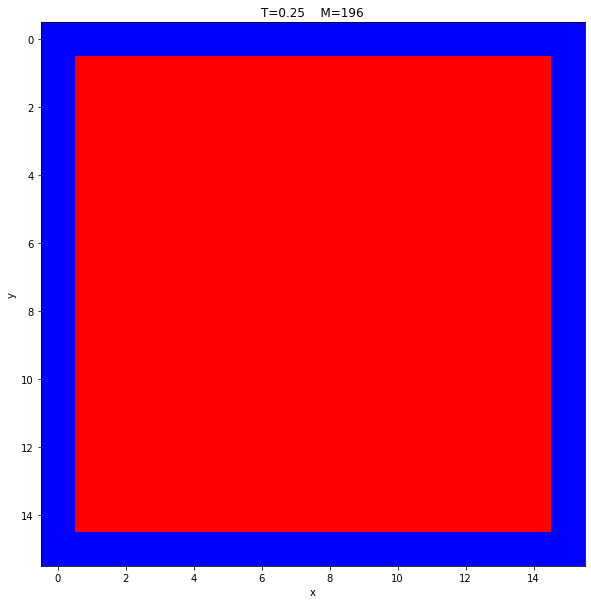

In [421]:
length = 100
T_arr = np.linspace(0.01, 6, length)[::-1]
M_, M2_ = np.zeros(length), np.zeros(length)
E_, E2_ = np.zeros(length), np.zeros(length)
std_E = np.zeros(length)
std_M = np.zeros(length)
configurations = []

x, y, init_matrix, N = init_accusations(L=16, mode='random')

n_runs = 10
for n_run in range(n_runs):  
    clear_output(wait=True)
    plot_lattice_plt(init_matrix, 'Initial state')
    matrix = init_matrix.copy()
    for T, step in zip(T_arr, range(length)):

        matrix, _, _ = run(matrix, T, mode='loop')
        calc = matrix.copy()
        _, E_temp, M_temp = run(calc, T, mode='calc')

        E_[step] += E_temp.sum() / len(E_temp) / n_runs
        M_[step] += M_temp.sum() / len(M_temp) / n_runs
        
        std_E[step] += E_temp.std() / len(E_temp) / n_runs
        std_M[step] += M_temp.std() / len(M_temp) / n_runs

        E2_[step] += (E_temp ** 2).sum() / len(E_temp) / n_runs
        M2_[step] += (M_temp ** 2).sum() / len(M_temp) / n_runs

        if step % 5 == 0:
            clear_output(wait=True)
            plot_lattice_plt(matrix, 'T='+str(round(T, 2)) + '    M=' + str(matrix.sum()))
    
    configurations.append(matrix)

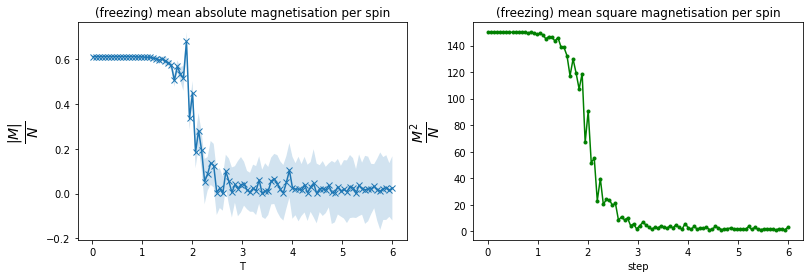

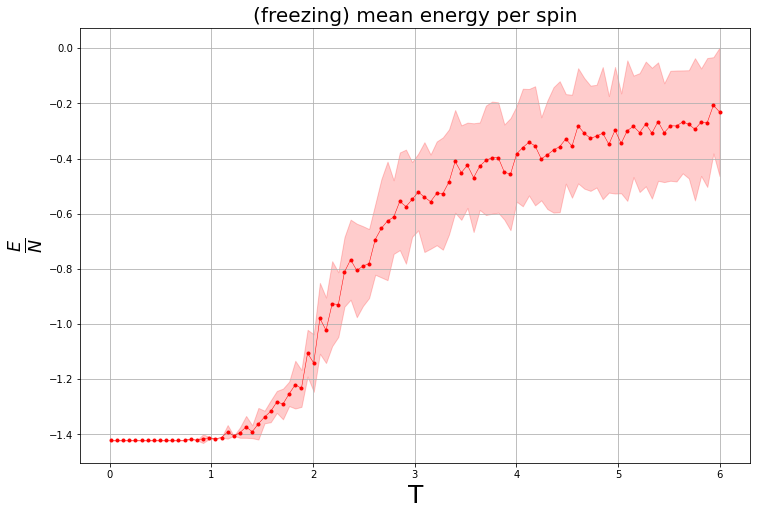

In [422]:
T_=T_arr
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].plot(T_, abs(M_) / N,  'x-')
ax[0].fill_between(T_, abs(M_) / N - std_M, abs(M_) / N + std_M, alpha=0.2)
ax[1].plot(T_, abs(M2_) / N, '.-', color='green')
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20), ax[1].set_ylabel(r'$\frac{M^2}{N}$', fontsize=20)
ax[0].set_title('(freezing) mean absolute magnetisation per spin')
ax[1].set_title('(freezing) mean square magnetisation per spin')
plt.show()

plt.figure(figsize=(12, 8))
plt.fill_between(T_, E_ / N - std_E, E_ / N + std_E, alpha=0.2, color='red')
plt.plot(T_, E_ / N, '.-',lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.title('(freezing) mean energy per spin', fontsize=20), plt.grid()
plt.show()

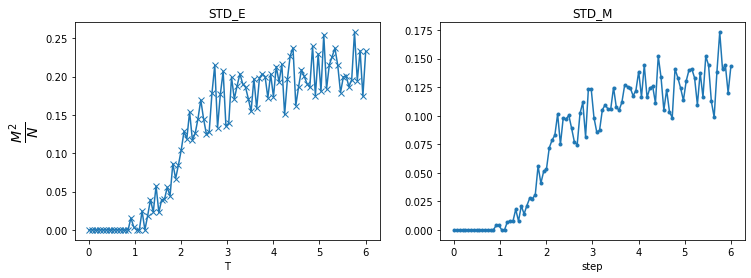

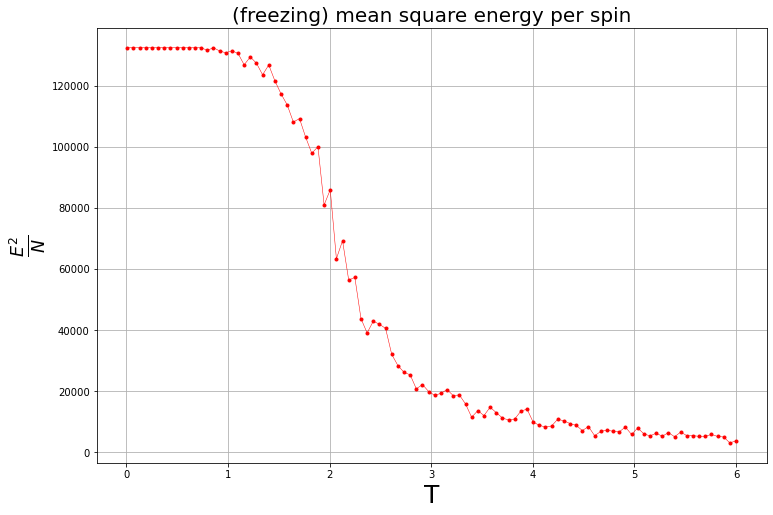

In [423]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(T_, std_E,  'x-')
ax[1].plot(T_, std_M, '.-')
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20), ax[0].set_ylabel(r'$\frac{M^2}{N}$', fontsize=20)
ax[0].set_title('STD_E')
ax[1].set_title('STD_M')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(T_, E2_, '.-',lw=0.5, color='red')
#plt.yscale('log')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E^2}{N}$', fontsize=25)
plt.title('(freezing) mean square energy per spin', fontsize=20), plt.grid()
plt.show()

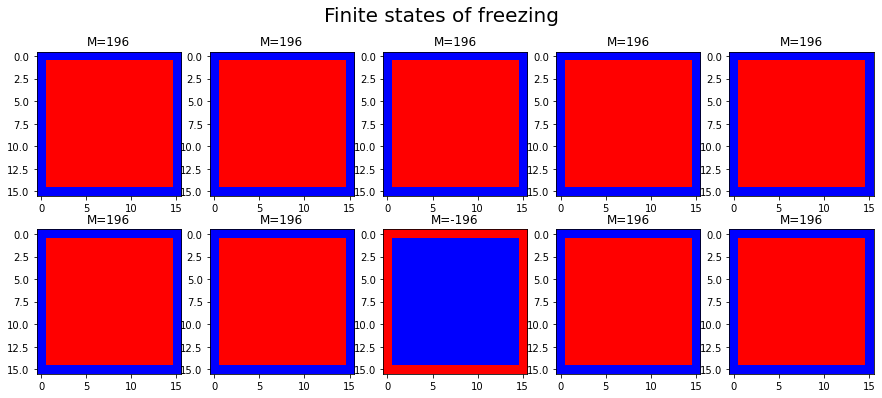

In [424]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Finite states of freezing', fontsize=20)
for ax, conf in zip(fig.get_axes(), configurations):
    plot_lattice(conf, ax, 'M='+str(conf.sum()))

In [425]:
#save
df = pd.DataFrame([])
df['T'] = T_
df['E'] = E_
df['M'] = M_
df['E2'] = E2_
df['M2'] = M2_
df['std_E']=std_E
df['std_M']=std_M

In [426]:
df.head()

,T,E,M,E2,M2,std_E,std_M
0,6.000000,-59.160,6.032,3858.576,794.080,0.233002,0.143496
1,5.939495,-52.992,-4.144,3071.392,286.144,0.174563,0.119980
2,5.878990,-68.968,-6.976,5048.016,391.680,0.233768,0.144531
3,5.818485,-68.656,5.808,5224.640,467.744,0.194877,0.140490
4,5.757980,-75.280,-2.768,5881.408,252.960,0.257895,0.173055


In [427]:
df.to_csv('data_freezing_L16_T100_long.csv', index=False)

### Melting

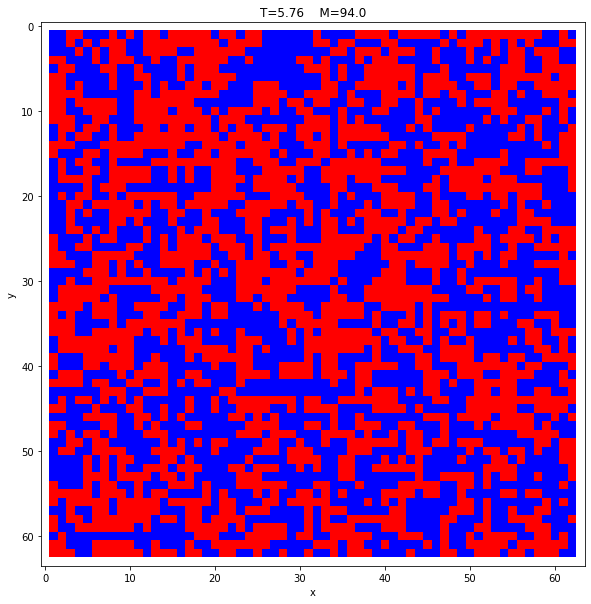

In [803]:
length = 100
n_runs = 10

T_arr = np.linspace(0.01, 6, length)
M_, M2_ = np.zeros((length, n_runs)), np.zeros((length, n_runs))
E_, E2_ = np.zeros((length, n_runs)), np.zeros((length, n_runs))
std_E = np.zeros((length, n_runs))
std_M = np.zeros((length, n_runs))
configurations = []

x, y, init_matrix, N = init_accusations(L=64, mode='filled')

for n_run in range(n_runs):  
    clear_output(wait=True)
    plot_lattice_plt(init_matrix, 'Initial state')
    matrix = init_matrix.copy()
    for T, step in zip(T_arr, range(length)):

        matrix, _, _ = run(matrix, T, mode='loop')
        calc = matrix.copy()
        _, E_temp, M_temp = run(calc, T, mode='calc')

        E_[step][n_run] += E_temp.sum() / len(E_temp) / n_runs
        M_[step][n_run] += M_temp.sum() / len(M_temp) / n_runs
        
        std_E[step][n_run] += E_temp.std() / len(E_temp) / n_runs
        std_M[step][n_run] += M_temp.std() / len(M_temp) / n_runs

        E2_[step][n_run] += (E_temp ** 2).sum() / len(E_temp) / n_runs
        M2_[step][n_run] += (M_temp ** 2).sum() / len(M_temp) / n_runs

        if step % 5 == 0:
            clear_output(wait=True)
            plot_lattice_plt(matrix, 'T='+str(round(T, 2)) + '    M=' + str(matrix.sum()))
    
    configurations.append(matrix)

In [804]:
meanM_ = M_.sum(axis = 1) / M_.shape[1]
meanM2_ = M2_.sum(axis = 1) / M_.shape[1]
meanE_ = E_.sum(axis = 1) / M_.shape[1]
meanE2_ = E2_.sum(axis = 1) / M_.shape[1]
meanstd_M = std_M.sum(axis = 1) / M_.shape[1]
meanstd_E = std_E.sum(axis = 1) / M_.shape[1]

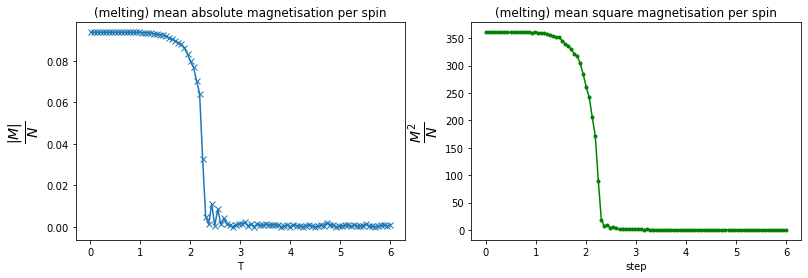

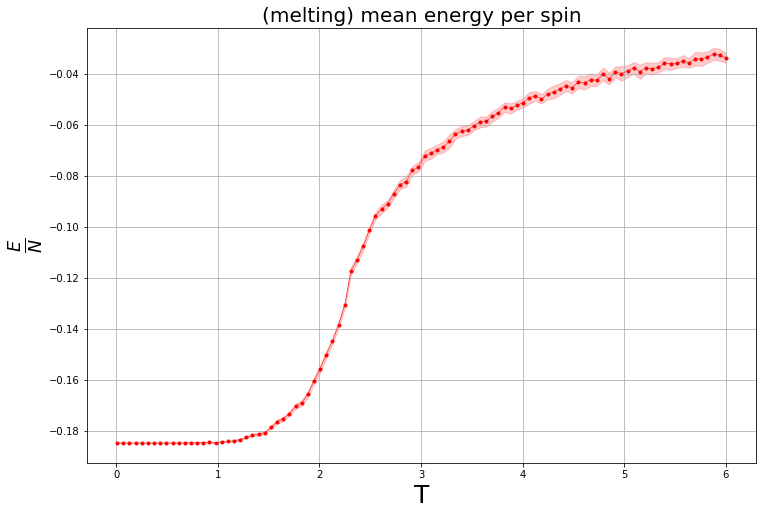

In [805]:
T_=T_arr
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].plot(T_, abs(meanM_) / N,  'x-')
ax[0].fill_between(T_, abs(meanM_) / N - meanstd_M, abs(meanM_) / N + meanstd_M, alpha=0.2)
ax[1].plot(T_, abs(meanM2_) / N, '.-', color='green')
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20), ax[1].set_ylabel(r'$\frac{M^2}{N}$', fontsize=20)
ax[0].set_title('(melting) mean absolute magnetisation per spin')
ax[1].set_title('(melting) mean square magnetisation per spin')
plt.show()

plt.figure(figsize=(12, 8))
plt.fill_between(T_, meanE_ / N - meanstd_E, meanE_ / N + meanstd_E, alpha=0.2, color='red')
plt.plot(T_, meanE_ / N, '.-',lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.title('(melting) mean energy per spin', fontsize=20), plt.grid()
plt.show()

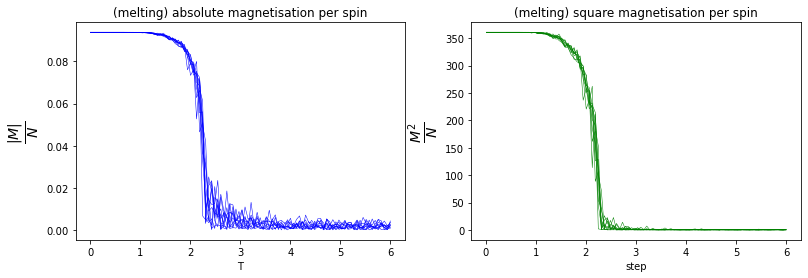

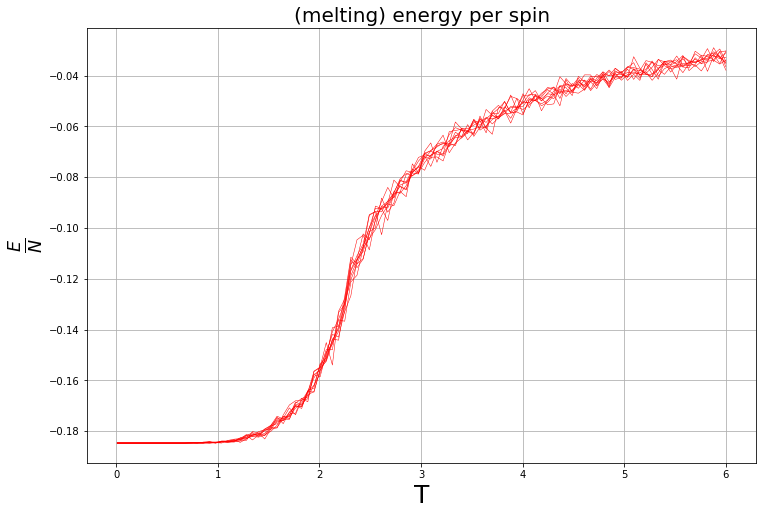

In [806]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
for i in range(n_runs):
    ax[0].plot(T_, abs(M_[:, i]) / N, lw=0.5, color='blue')
    ax[1].plot(T_, abs(M2_[:, i]) / N, lw=0.5, color='green')
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20), ax[1].set_ylabel(r'$\frac{M^2}{N}$', fontsize=20)
ax[0].set_title('(melting) absolute magnetisation per spin')
ax[1].set_title('(melting) square magnetisation per spin')
plt.show()

plt.figure(figsize=(12, 8))
for i in range(n_runs):
    plt.plot(T_, E_[:, i] / N, lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.title('(melting) energy per spin', fontsize=20), plt.grid()
plt.show()

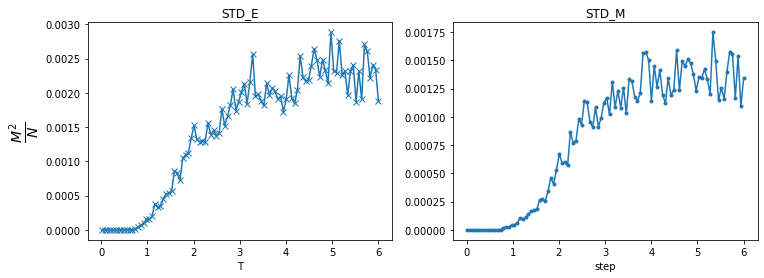

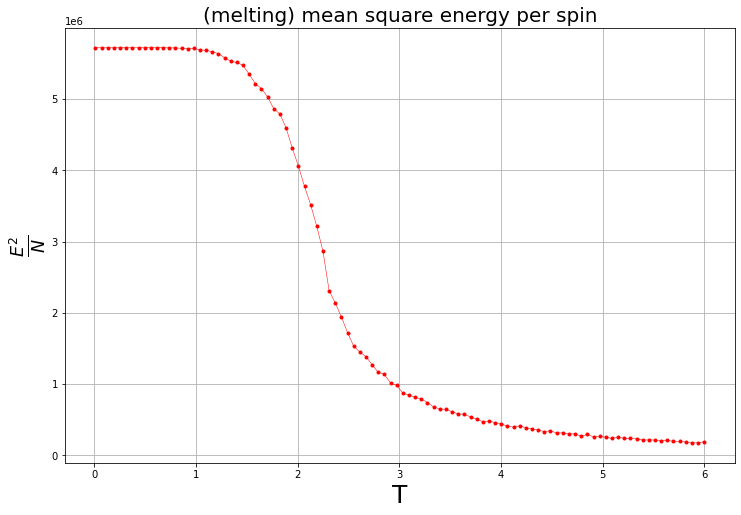

In [807]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(T_, meanstd_E,  'x-')
ax[1].plot(T_, meanstd_M, '.-')
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20), ax[0].set_ylabel(r'$\frac{M^2}{N}$', fontsize=20)
ax[0].set_title('STD_E')
ax[1].set_title('STD_M')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(T_, meanE2_, '.-',lw=0.5, color='red')
#plt.yscale('log')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E^2}{N}$', fontsize=25)
plt.title('(melting) mean square energy per spin', fontsize=20), plt.grid()
plt.show()

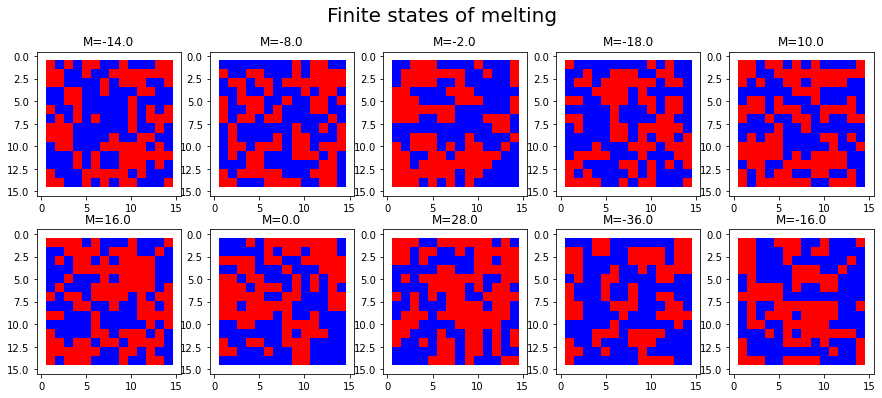

In [417]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Finite states of melting', fontsize=20)
for ax, conf in zip(fig.get_axes(), configurations):
    plot_lattice(conf, ax, 'M='+str(conf.sum()))

In [418]:
#save
df = pd.DataFrame([])
df['T'] = T_
df['E'] = meanE_
df['M'] = meanM_
df['E2'] = meanE2_
df['M2'] = meanM2_
df['std_E']=meanstd_E
df['std_M']=meanstd_M

In [419]:
df.head()

,T,E,M,E2,M2,std_E,std_M
0,0.010000,-36.4,19.6,13249.6,3841.6,0.0,0.0
1,0.070505,-36.4,19.6,13249.6,3841.6,0.0,0.0
2,0.131010,-36.4,19.6,13249.6,3841.6,0.0,0.0
3,0.191515,-36.4,19.6,13249.6,3841.6,0.0,0.0
4,0.252020,-36.4,19.6,13249.6,3841.6,0.0,0.0


In [420]:
df.to_csv('data_melting_L16_T100_filled.csv', index=False)

# Read data

In [690]:
def append_data(data, filename='data_melting_L16_T100_filled.csv', suffix='_m_16'):
    df = pd.read_csv(filename)
    for col in df.columns:
        data[col+suffix] = df[col]
    return data

In [822]:
files = [
    ['data_melting_L16_T100_filled.csv', '_m_16'],
    ['data_melting_L32_T100_filled.csv', '_m_32'],
    ['data_melting_L64_T100_filled.csv', '_m_64'],
    ['data_freezing_L16_T100_long.csv', '_f_16'],
    ['data_freezing_L32_T100_long.csv', '_f_32'],
    ['data_freezing_L64_T100_long.csv', '_f_64'],
]

data = pd.DataFrame([])
for f, s in files:
    data = append_data(data, f, s)

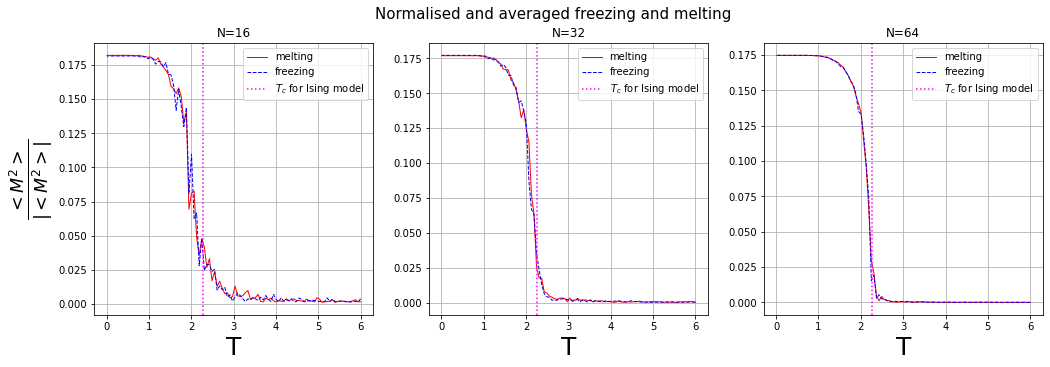

In [834]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
for d, color, ls, label in zip(['m', 'f'], ['red', 'blue'], ['-', '--'], ['melting', 'freezing']):
    
    ax[0].set_ylabel(r'$\frac{<M^2>}{|<M^2>|}$', fontsize=25)
    plt.suptitle('Normalised and averaged freezing and melting', fontsize=15)
    for N, i in zip([16, 32, 64], range(3)):
        T_ = data['T_'+d+'_'+str(N)] 
        M2_ = data['M2_'+d+'_'+str(N)]
        M2_ = M2_ / np.linalg.norm(np.array(M2_))
        ax[i].plot(T_, abs(M2_) , ls, lw=1, label=label, color=color)
        ax[i].set_xlabel('T', fontsize=25)

        ax[i].set_title('N='+str(N))
for i in range(3):
    ax[i].grid()
    ax[i].axvline(2.269, ls=':', label=r'$T_c$ for Ising model', color='magenta')
    ax[i].legend()

In [855]:
files = [
    ['data_L32_T100_updown.csv', '_u_32'],
    ['data_L64_T100_updown.csv', '_u_64'],
    ['data_L80_T100_updown.csv', '_u_80'],
    ['data_L100_T100_updown.csv', '_u_100'],
    ['data_L150_T100_updown.csv', '_u_150'],
    ['data_L200_T100_updown.csv', '_u_200'],
]

data = pd.DataFrame([])
for f, s in files:
    data = append_data(data, f, s)

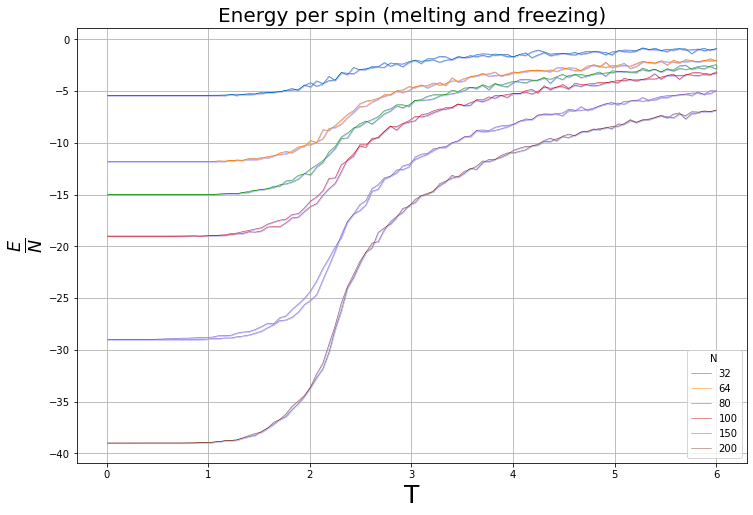

In [856]:
plt.figure(figsize=(12, 8))
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.title('Energy per spin (melting and freezing)', fontsize=20), plt.grid()
for N in [32, 64, 80, 100, 150, 200]:

    T_ = data['T_u_'+str(N)] 
    E_ = data['E_u_'+str(N)]
    std_E = data['std_E_u_'+str(N)]
    plt.fill_between(T_, (E_) / N -std_E, (E_) / N+std_E, alpha=0.2, color=color)
    plt.plot(T_, E_/N , '-',lw=0.5, label=str(N))
plt.legend(title='N')
plt.show()

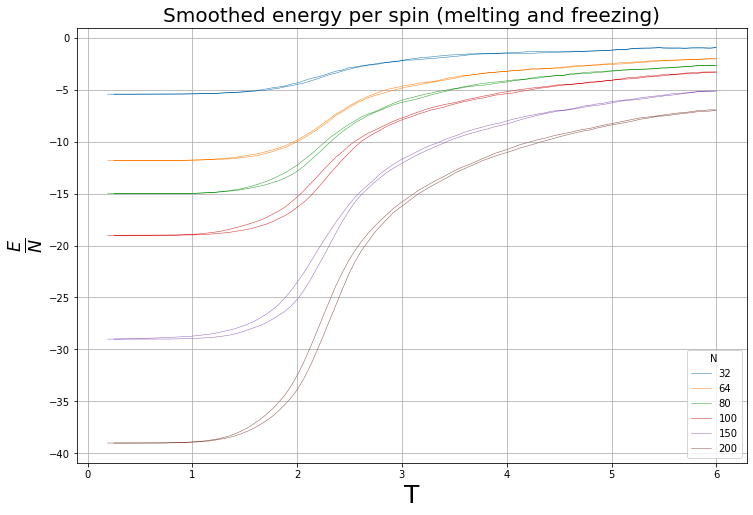

In [858]:
def ma(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.figure(figsize=(12, 8))
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.title('Smoothed energy per spin (melting and freezing)', fontsize=20), plt.grid()
for N in [32, 64, 80, 100, 150, 200]:

    T_ = data['T_u_'+str(N)] 
    E_ = data['E_u_'+str(N)]
    std_E = data['std_E_u_'+str(N)]
    plt.plot(T_[4:-3], ma(E_, 8) / N, '-',lw=0.5, label=str(N))
plt.legend(title='N')
plt.show()

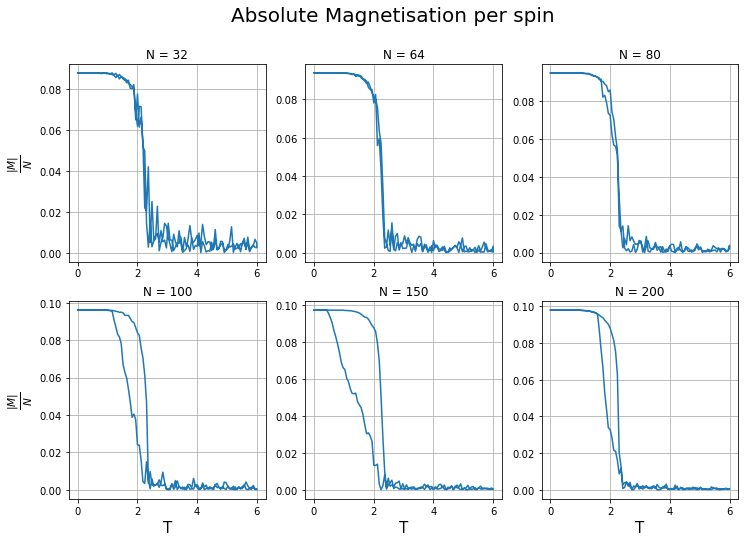

In [749]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Absolute Magnetisation per spin', fontsize=20)
for axi, N in zip(fig.get_axes(), [32, 64, 80, 100, 150, 200]):
    
    T_ = data['T_u_'+str(N)] 
    M_ = data['M_u_'+str(N)]
    std_M = data['std_M_u_'+str(N)]
    
    axi.plot(T_, abs(M_) / N/N)
    #axi.fill_between(T_, abs(M_) / N- std_M, abs(M_) / N + std_M, alpha=0.2)
    
    axi.set_title('N = '+str(N))
    if (N >80):
        axi.set_xlabel('T', fontsize=15)
    if (N == 32) or (N == 100):
        axi.set_ylabel(r'$\frac{|M|}{N}$', fontsize=15)
    axi.grid()

plt.show()

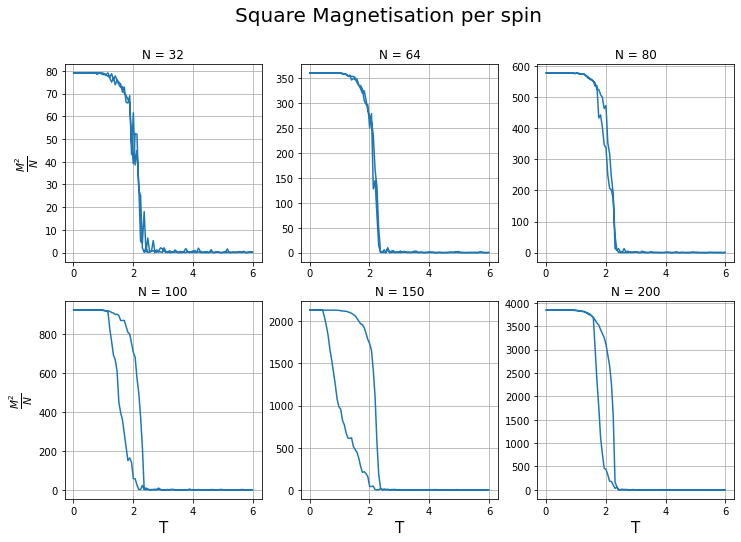

In [750]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Square Magnetisation per spin', fontsize=20)
for axi, N in zip(fig.get_axes(), [32, 64, 80, 100, 150, 200]):
    
    T_ = data['T_u_'+str(N)] 
    M2_ = data['M2_u_'+str(N)]
    std_M = data['std_M_u_'+str(N)]
    
    axi.plot(T_, abs(M2_) / N**2)
    axi.set_title('N = '+str(N))
    if (N >80):
        axi.set_xlabel('T', fontsize=15)
    if (N == 32) or (N == 100):
        axi.set_ylabel(r'$\frac{M^2}{N}$', fontsize=15)
    axi.grid()

plt.show()

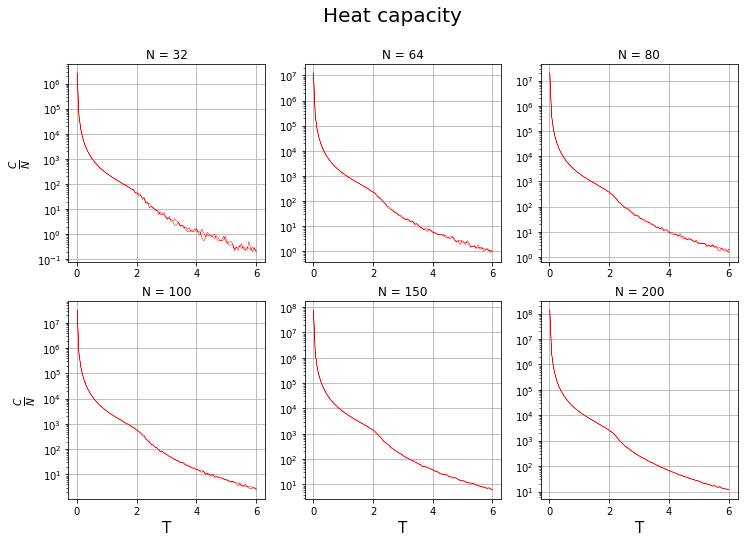

In [725]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Heat capacity', fontsize=20)
for axi, N in zip(fig.get_axes(), [32, 64, 80, 100, 150, 200]):   
    T_ = data['T_u_'+str(N)] 
    E_ = data['E_u_'+str(N)]
    E2_ = data['E2_u_'+str(N)]

    heat_capacity = 1 / (N ** 2 * T_**2) * (E2_ - E_**2)
    axi.plot(T_, heat_capacity, lw=0.5, color='red')

    axi.set_title('N = '+str(N))
    if (N >80):
        axi.set_xlabel('T', fontsize=15)
    if (N == 32) or (N == 100):
        axi.set_ylabel(r'$\frac{C}{N}$', fontsize=15)
    axi.grid()
    axi.set_yscale('log')

plt.show()

## Antiferomagnetic

In [808]:
@jit(nopython=True) #computation accelerator
def anti_est_E(matrix):
    L = len(matrix)
    E = 0
    
    for x_temp in range(1, L-1):
        for y_temp in range(1, L-1):
            
            # determine neighbours
            x_l = x_temp - 1 if x_temp > 0 else L - 1     # left
            x_r = x_temp + 1 if x_temp != L - 1 else 0    # right
            y_b = y_temp - 1 if y_temp > 0 else L - 1     # bottom
            y_t = y_temp + 1 if y_temp != L - 1 else 0    # top
            
            # calc flipping energy dE
            E += 1.0 * ( matrix[x_temp][y_temp] * matrix[x_l][y_temp] +\
                          matrix[x_temp][y_temp] * matrix[x_r][y_temp] +\
                          matrix[x_temp][y_temp] * matrix[x_temp][y_b] +\
                          matrix[x_temp][y_temp] * matrix[x_temp][y_t] )
            
    return E / 2

In [812]:
@jit(nopython=True) #computation accelerator
def anti_run(matrix, T, mode='loop'):
    L = len(matrix)
    N = L * L
        
    if mode == 'loop':
        loop = int(10**7)
    elif mode == 'calc':
        loop = int(0.5 * N)
    
    E = np.zeros(loop)
    M = np.zeros(loop)
    
    for step in range(loop):
    
        # choose random spot on lattice
        x_temp = np.random.randint(1, L-1)
        y_temp = np.random.randint(1, L-1)
        
        # determine neighbours
        x_l = x_temp - 1 if x_temp > 0 else L - 1     # left
        x_r = x_temp + 1 if x_temp != L - 1 else 0    # right
        y_b = y_temp - 1 if y_temp > 0 else L - 1     # bottom
        y_t = y_temp + 1 if y_temp != L - 1 else 0    # top
        
        # calc flipping energy dE
        E_before_flip = 1.0 * ( matrix[x_temp][y_temp] * matrix[x_l][y_temp] +\
                                 matrix[x_temp][y_temp] * matrix[x_r][y_temp] +\
                                 matrix[x_temp][y_temp] * matrix[x_temp][y_b] +\
                                 matrix[x_temp][y_temp] * matrix[x_temp][y_t] )
        E_after_flip = -E_before_flip
        dE = E_after_flip - E_before_flip
        
        # flip
        if (dE <= 0):
            
            # flip spin
            matrix[x_temp][y_temp] *= -1
            
        else:
            
            # check random number
            rand_temp = np.random.uniform(0, 1)
            if (rand_temp < np.exp(-dE/T)):
                
                # flip spin
                matrix[x_temp][y_temp] *= -1
                
        if mode == 'calc':
            E[step] = anti_est_E(matrix)
            M[step] = matrix.sum()
        
    return matrix, E, M

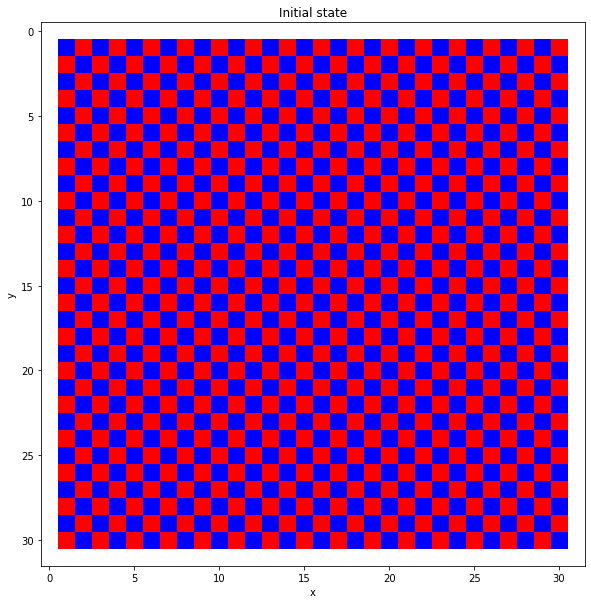

In [813]:
x, y, matrix, N = init_accusations(L=32, mode='grid', lw=1)
plot_lattice_plt(matrix, 'Initial state')

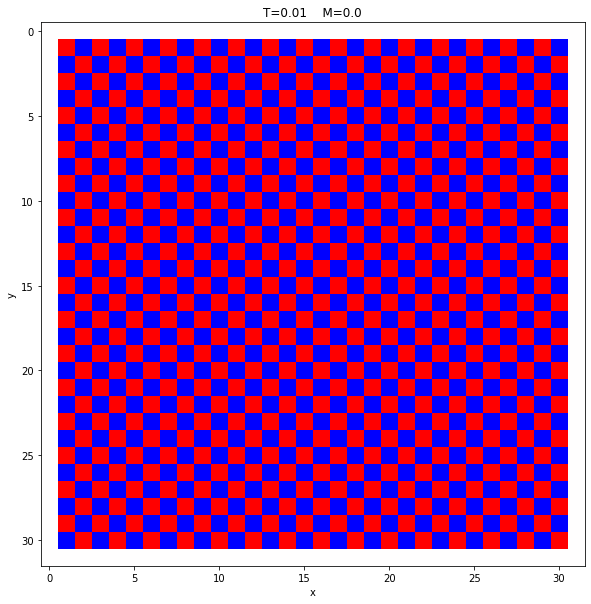

In [818]:
length = 100
# formation of T array
T_arr = np.linspace(0.01, 20, length)
T_ = np.append(T_arr, T_arr[::-1])
# measures        
M_, M2_ = np.zeros(length * 2), np.zeros(length * 2)
E_, E2_ = np.zeros(length * 2), np.zeros(length * 2)
std_E = np.zeros(length * 2)
std_M = np.zeros(length * 2)
configurations = []
# init
x, y, init_matrix, N = init_accusations(L=32, mode='grid', lw=1)
plot_lattice_plt(init_matrix, 'Initial state')
matrix = init_matrix.copy()
for T, step in zip(T_, range(length * 2)):

    matrix, _, _ = anti_run(matrix, T, mode='loop')
    calc = matrix.copy()
    _, E_temp, M_temp = anti_run(calc, T, mode='calc')

    E_[step] += E_temp.sum() / len(E_temp) / n_runs
    M_[step] += M_temp.sum() / len(M_temp) / n_runs

    std_E[step] += E_temp.std() / len(E_temp) / n_runs
    std_M[step] += M_temp.std() / len(M_temp) / n_runs

    E2_[step] += (E_temp ** 2).sum() / len(E_temp) / n_runs
    M2_[step] += (M_temp ** 2).sum() / len(M_temp) / n_runs

    if step % 5 == 0:
        clear_output(wait=True)
        plot_lattice_plt(matrix, 'T='+str(round(T, 2)) + '    M=' + str(matrix.sum()))

    if step % 10 == 0:
        configurations.append(matrix)
        

clear_output(wait=True)
plot_lattice_plt(matrix, 'T='+str(round(T, 2)) + '    M=' + str(matrix.sum()))

In [819]:
M_, M2_ = np.array(M_), np.array(M2_)
E_, E2_ = np.array(E_), np.array(E2_)
T_ = np.array(T_)

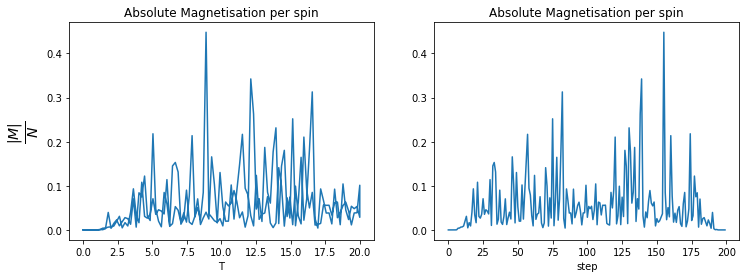

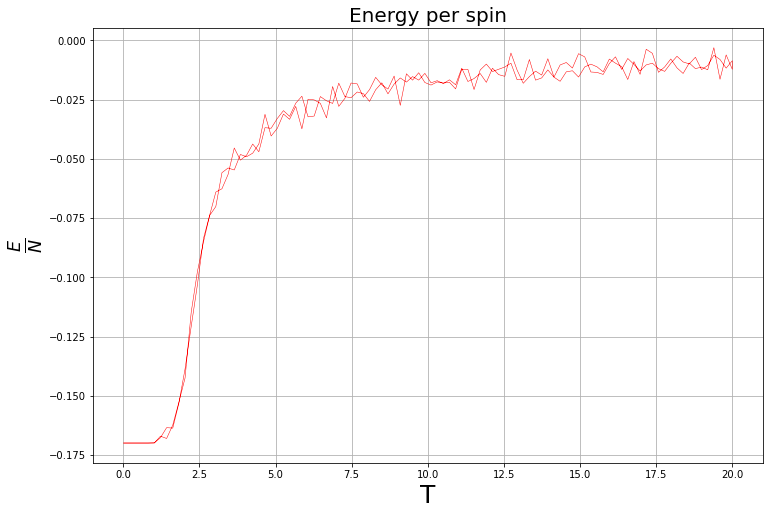

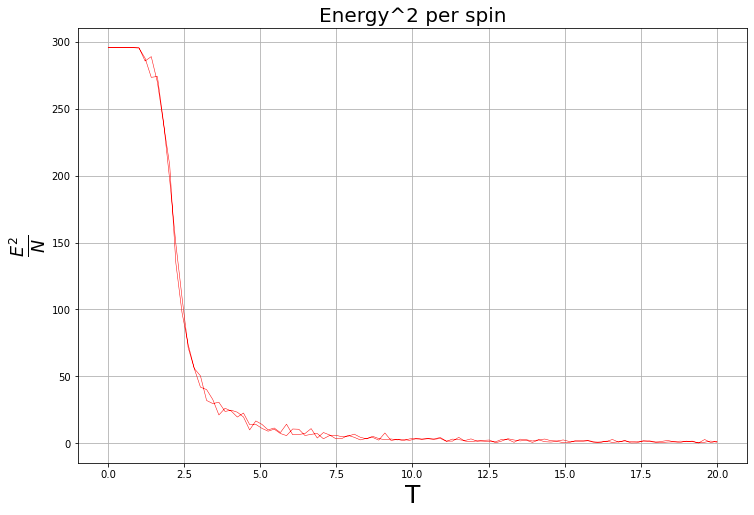

In [820]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(T_, abs(M2_) / N)
ax[1].plot(abs(M2_) / N)
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20), ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20)
ax[0].set_title('Absolute Magnetisation per spin')
ax[1].set_title('Absolute Magnetisation per spin')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(T_, E_ / N, lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.title('Energy per spin', fontsize=20), plt.grid()
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(T_, E2_ / N, lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E^2}{N}$', fontsize=25)
plt.title('Energy^2 per spin', fontsize=20), plt.grid()
plt.show()

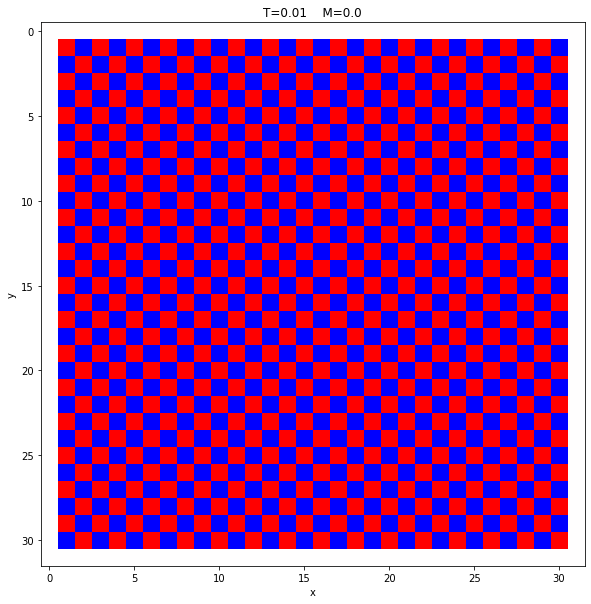

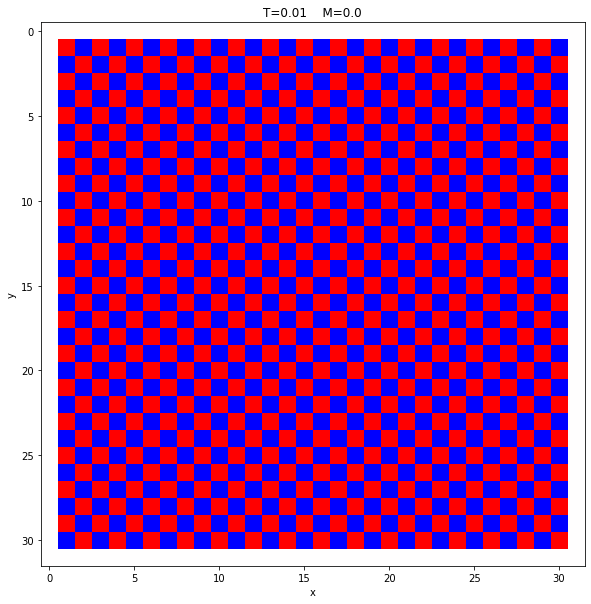

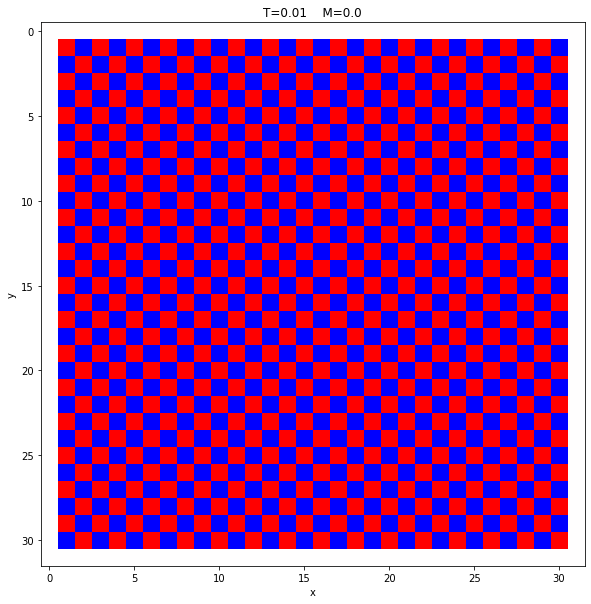

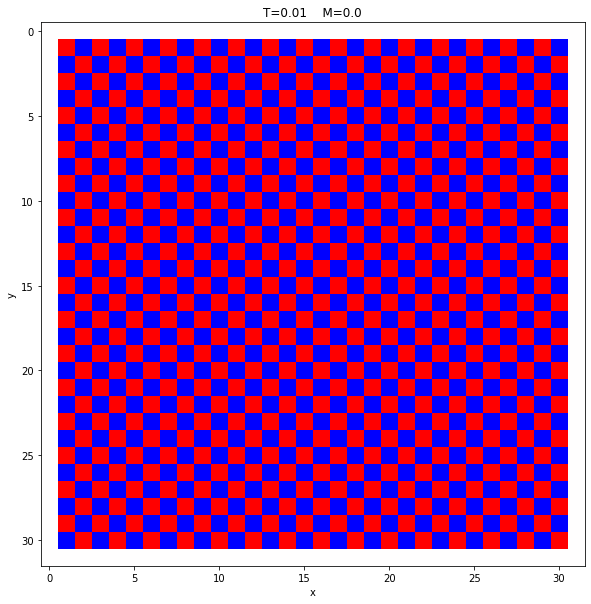

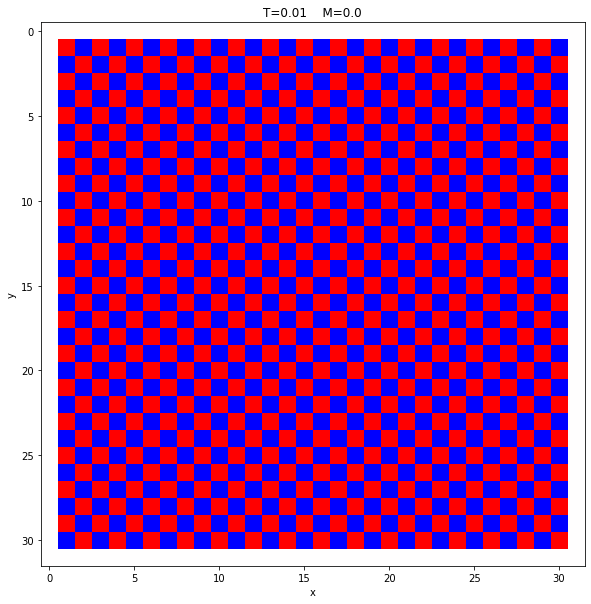

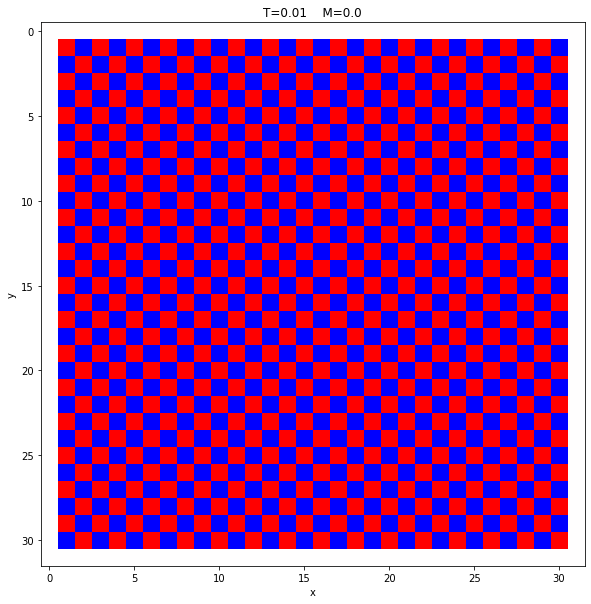

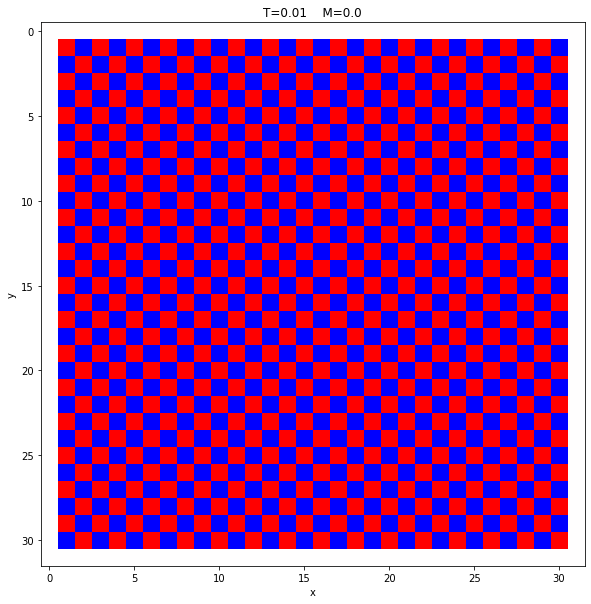

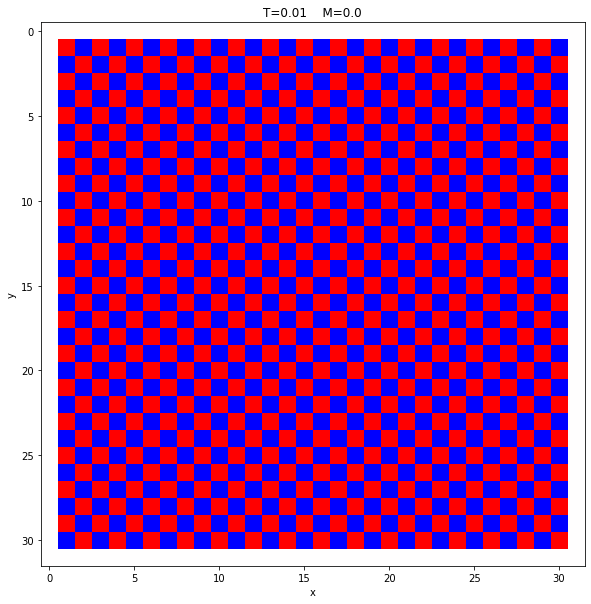

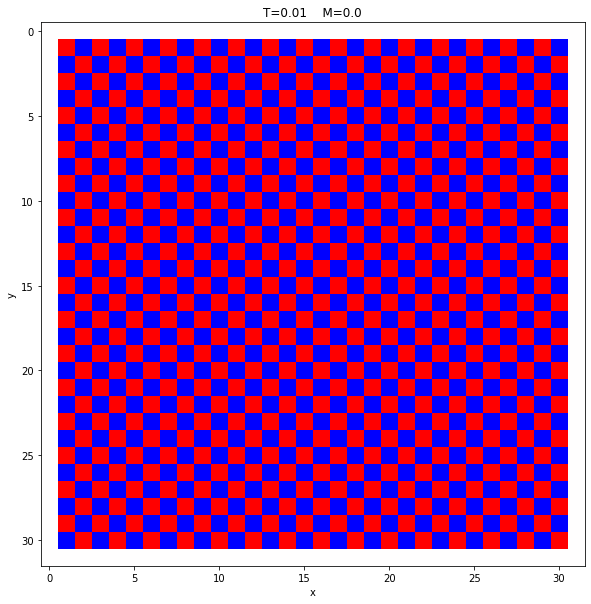

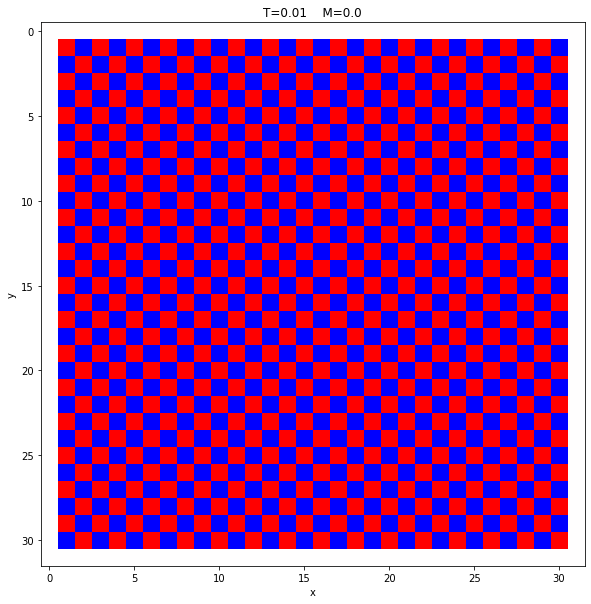

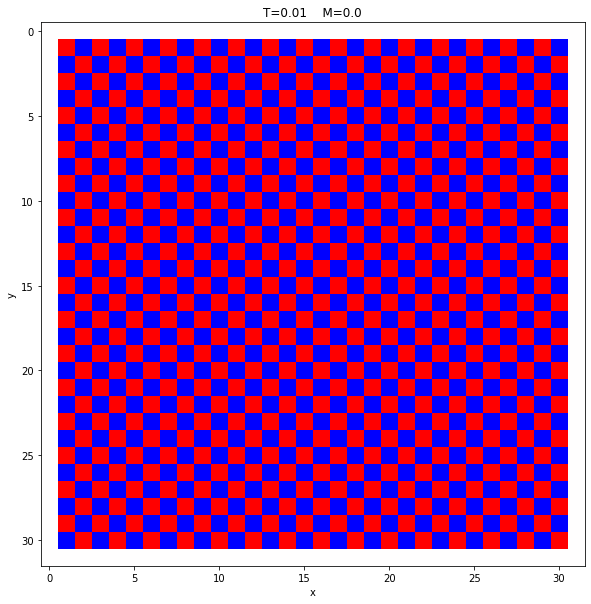

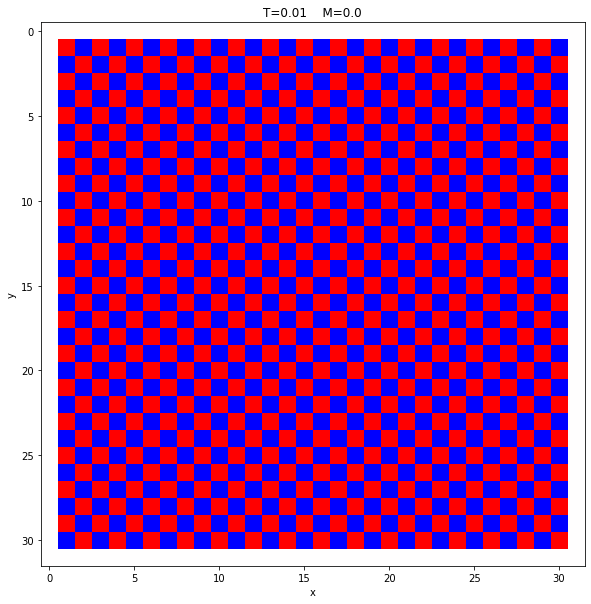

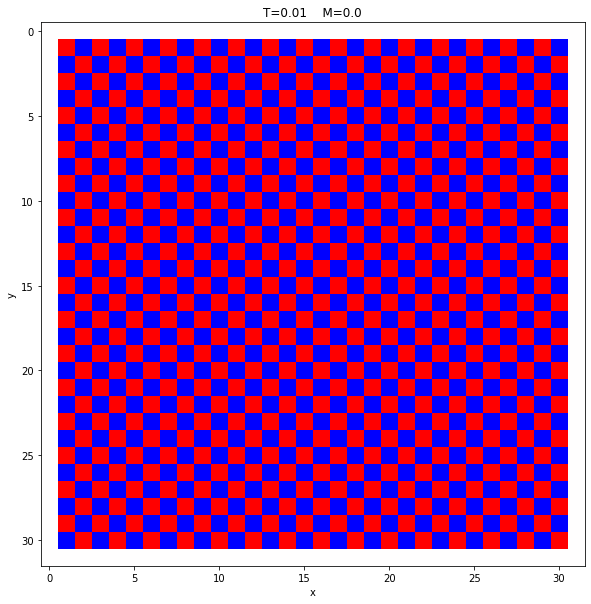

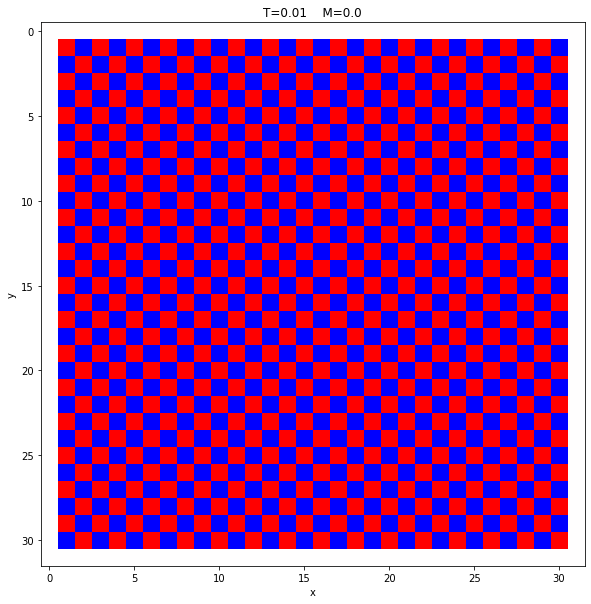

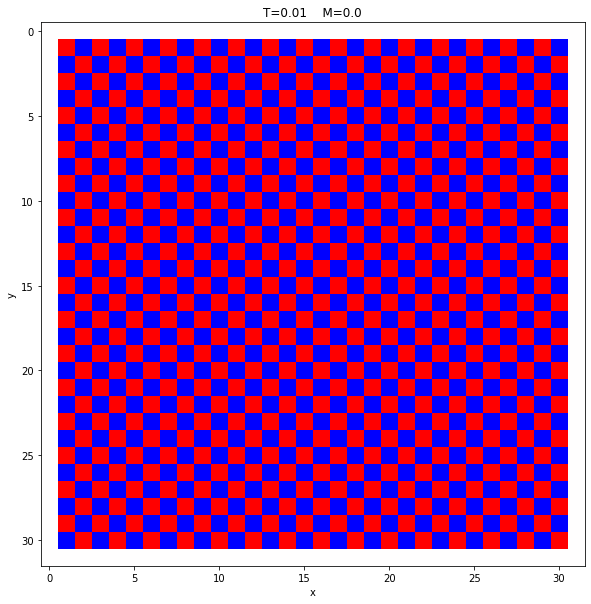

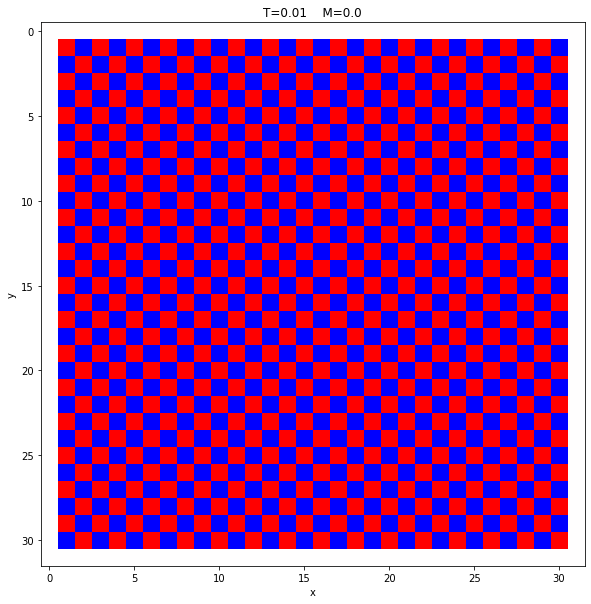

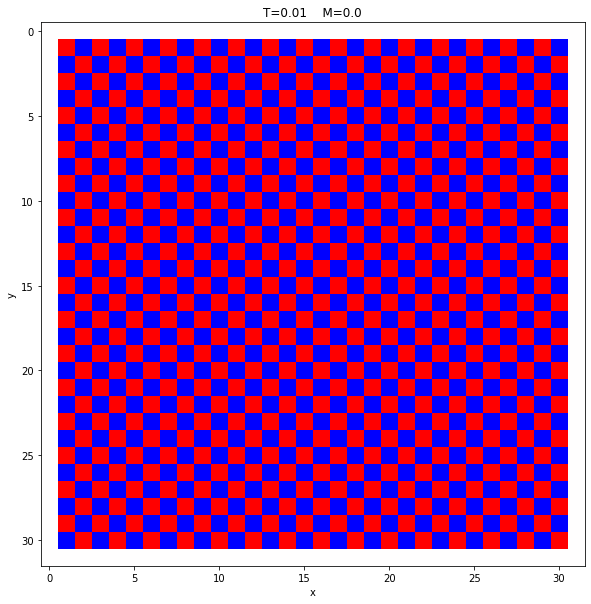

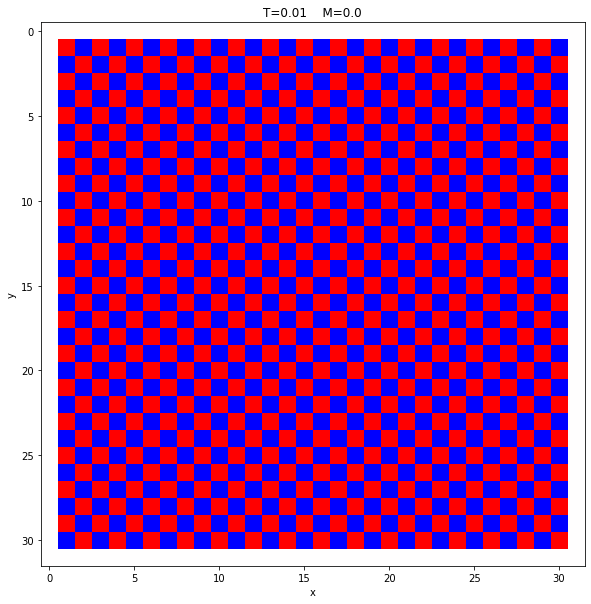

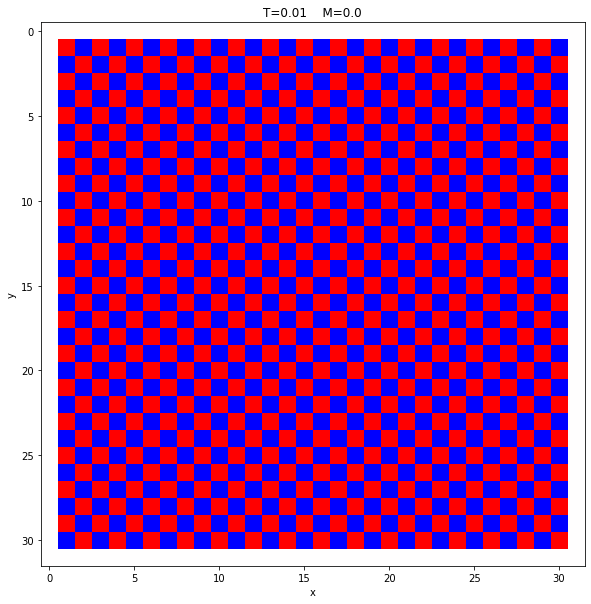

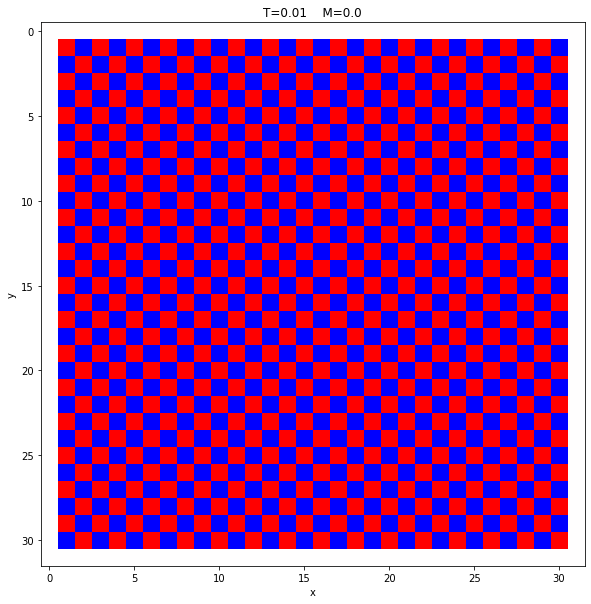

In [821]:
for conf in configurations:
    plot_lattice_plt(conf, 'T='+str(round(T, 2)) + '    M=' + str(matrix.sum()))

# Other freezing

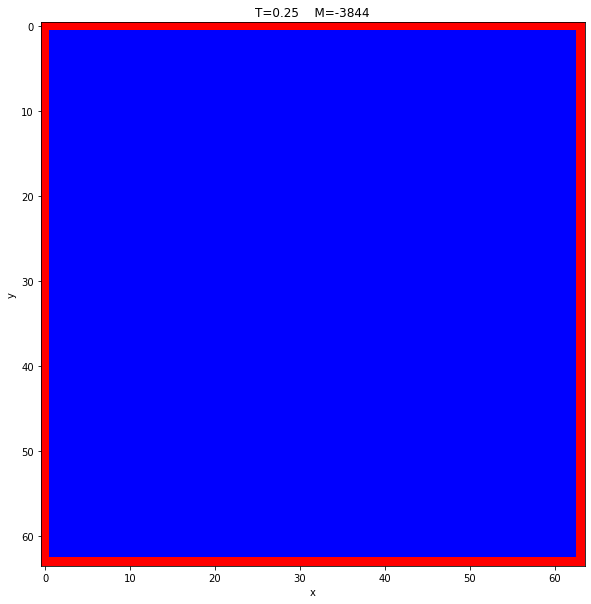

In [837]:
length = 100
n_runs = 10

T_arr = np.linspace(6, 0.01, length)
M_, M2_ = np.zeros((length, n_runs)), np.zeros((length, n_runs))
E_, E2_ = np.zeros((length, n_runs)), np.zeros((length, n_runs))
std_E = np.zeros((length, n_runs))
std_M = np.zeros((length, n_runs))
configurations = []

x, y, init_matrix, N = init_accusations(L=64, mode='random')

for n_run in range(n_runs):  
    clear_output(wait=True)
    plot_lattice_plt(init_matrix, 'Initial state')
    matrix = init_matrix.copy()
    for T, step in zip(T_arr, range(length)):

        matrix, _, _ = run(matrix, T, mode='loop')
        calc = matrix.copy()
        _, E_temp, M_temp = run(calc, T, mode='calc')

        E_[step][n_run] += E_temp.sum() / len(E_temp) / n_runs
        M_[step][n_run] += M_temp.sum() / len(M_temp) / n_runs
        
        std_E[step][n_run] += E_temp.std() / len(E_temp) / n_runs
        std_M[step][n_run] += M_temp.std() / len(M_temp) / n_runs

        E2_[step][n_run] += (E_temp ** 2).sum() / len(E_temp) / n_runs
        M2_[step][n_run] += (M_temp ** 2).sum() / len(M_temp) / n_runs

        if step % 5 == 0:
            clear_output(wait=True)
            plot_lattice_plt(matrix, 'T='+str(round(T, 2)) + '    M=' + str(matrix.sum()))
    
    configurations.append(matrix)

In [850]:
meanM_ = abs(M_).sum(axis = 1) / M_.shape[1]
meanM2_ = M2_.sum(axis = 1) / M_.shape[1]
meanE_ = E_.sum(axis = 1) / M_.shape[1]
meanE2_ = E2_.sum(axis = 1) / M_.shape[1]
meanstd_M = std_M.sum(axis = 1) / M_.shape[1]
meanstd_E = std_E.sum(axis = 1) / M_.shape[1]

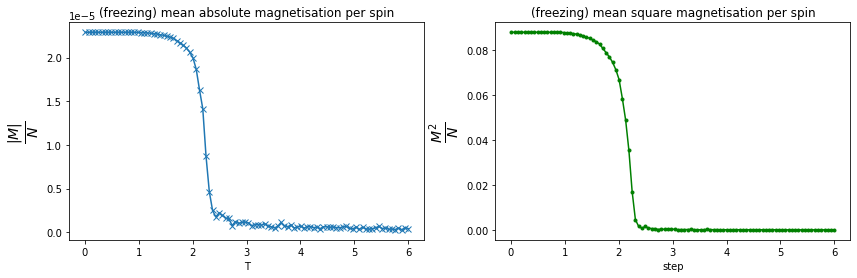

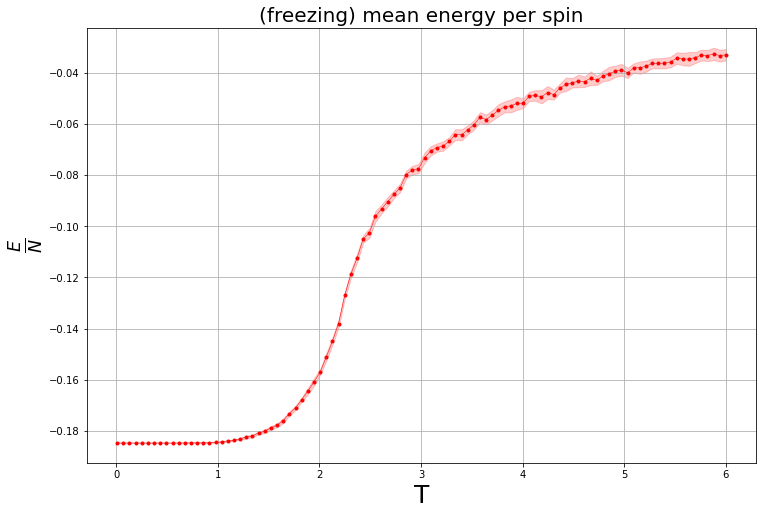

In [851]:
T_=T_arr
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(T_, abs(meanM_)/N/N,  'x-')
#ax[0].fill_between(T_, abs(meanM_) / N/N - meanstd_M, abs(meanM_) / N/N + meanstd_M, alpha=0.2)
ax[1].plot(T_, abs(meanM2_)/N**2, '.-', color='green')
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20), ax[1].set_ylabel(r'$\frac{M^2}{N}$', fontsize=20)
ax[0].set_title('(freezing) mean absolute magnetisation per spin')
ax[1].set_title('(freezing) mean square magnetisation per spin')
plt.show()

plt.figure(figsize=(12, 8))
plt.fill_between(T_, meanE_ / N - meanstd_E, meanE_ / N + meanstd_E, alpha=0.2, color='red')
plt.plot(T_, meanE_ / N, '.-',lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.title('(freezing) mean energy per spin', fontsize=20), plt.grid()
plt.show()

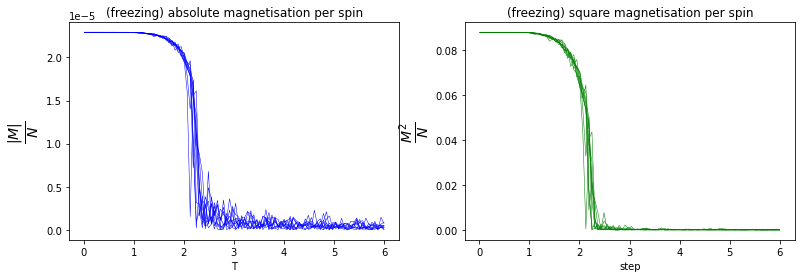

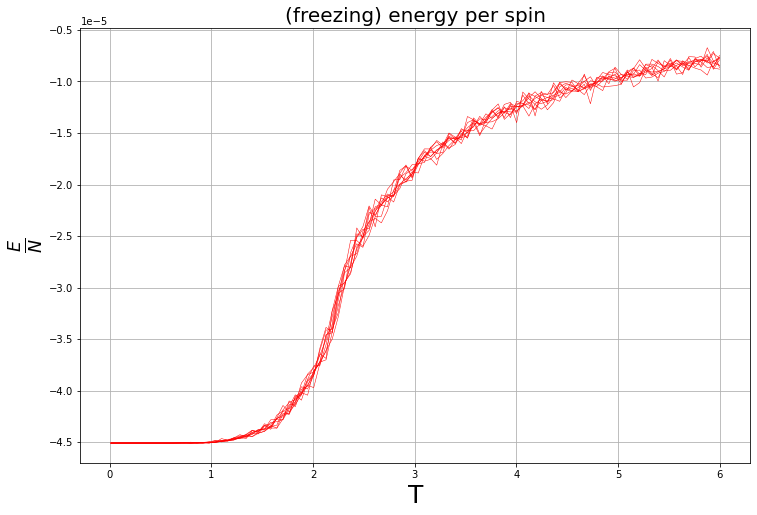

In [846]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
for i in range(n_runs):
    ax[0].plot(T_, abs(M_[:, i]) / N/N, lw=0.5, color='blue')
    ax[1].plot(T_, abs(M2_[:, i]) / N/N, lw=0.5, color='green')
ax[0].set_xlabel('T'), ax[1].set_xlabel('step')
ax[0].set_ylabel(r'$\frac{|M|}{N}$', fontsize=20), ax[1].set_ylabel(r'$\frac{M^2}{N}$', fontsize=20)
ax[0].set_title('(freezing) absolute magnetisation per spin')
ax[1].set_title('(freezing) square magnetisation per spin')
plt.show()

plt.figure(figsize=(12, 8))
for i in range(n_runs):
    plt.plot(T_, E_[:, i] / N/N, lw=0.5, color='red')
plt.xlabel('T', fontsize=25), plt.ylabel(r'$\frac{E}{N}$', fontsize=25)
plt.title('(freezing) energy per spin', fontsize=20), plt.grid()
plt.show()

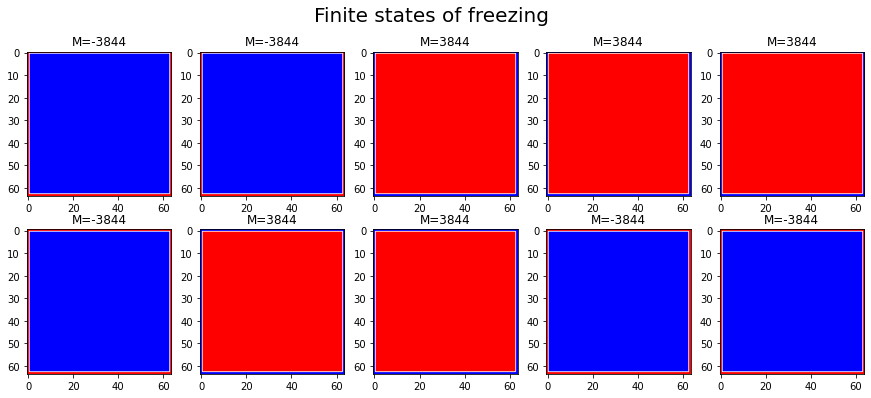

In [849]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Finite states of freezing', fontsize=20)
for ax, conf in zip(fig.get_axes(), configurations):
    plot_lattice(conf, ax, 'M='+str(conf.sum()))